# Wasserstein GAN

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as D
import torchvision
import torchvision.transforms as transforms
import pyblaze.nn as xnn
import pyblaze.nn.functional as X
import matplotlib.pyplot as plt

In [2]:
train_dataset = torchvision.datasets.MNIST(
    root="~/Downloads/", train=True, download=True, transform=transforms.ToTensor()
)

In [3]:
noise_dataset = xnn.NoiseDataset(D.Normal(torch.zeros(2), torch.ones(2)))

In [4]:
critic_iterations = 3

In [5]:
train_loader = train_dataset.loader(batch_size=256, num_workers=4, drop_last=True, shuffle=True)
noise_loader = noise_dataset.loader(batch_size=256)
zip_loader = xnn.ZipDataLoader(noise_loader, train_loader, critic_iterations+1, critic_iterations)

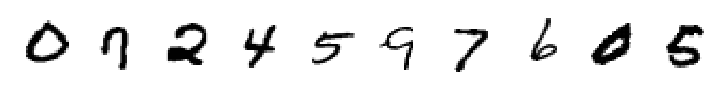

In [6]:
plt.figure(dpi=150)

images = [train_dataset[i] for i in np.random.choice(len(train_dataset), 10)]
for i, (image, _) in enumerate(images):
    plt.subplot(1, 10, i+1)
    plt.imshow(image[0], cmap='binary')
    plt.axis('off')

plt.show()

In [11]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 6272),
            nn.ReLU(),
            xnn.View(-1, 128, 7, 7),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.conv(noise)

class Critic(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(2304, 1)
        )
        
    def forward(self, x):
        return self.conv(x)


class WGAN(nn.Module):

    def __init__(self):
        super().__init__()
        self.generator = Generator()
        self.critic = Critic()

    def forward(self, noise):
        fake = self.generator(noise)
        return self.critic(fake)

In [12]:
model = WGAN()

print(f'Total parameters:     {sum(p.numel() for p in model.parameters()):6,}')
print(f'Generator parameters: {sum(p.numel() for p in model.generator.parameters()):6,}')
print(f'Critic parameters:    {sum(p.numel() for p in model.critic.parameters()):6,}')

Total parameters:     1,928,450
Generator parameters: 974,401
Critic parameters:    954,049


In [13]:
generator_optimizer = optim.Adam(model.generator.parameters(), lr=3e-4)
critic_optimizer = optim.Adam(model.critic.parameters(), lr=3e-4)
generator_loss = xnn.WassersteinLossGenerator()
gp = xnn.GradientPenalty(model.critic, lipschitz=True)
critic_loss = xnn.WassersteinLossCritic(gp)

In [14]:
engine = xnn.WGANEngine(model, ignore_target=True)

In [15]:
class Callback(xnn.TrainingCallback):
    
    def __init__(self, generator):
        self.generator = generator
        self.epoch = None
        
    def before_epoch(self, epoch, iterations):
        self.epoch = epoch
    
    def after_epoch(self, metrics):
        if self.epoch % 10 == 0:
            noise = next(iter(noise_loader)).cuda()
            with torch.no_grad():
                out = self.generator(noise).cpu().detach().numpy()
            plt.figure(dpi=150)

            for i in range(10):
                plt.subplot(1, 10, i+1)
                plt.imshow(out[i].reshape(28, 28), cmap='binary')
                plt.axis('off')

            plt.show()

Epoch 1/150:
 [Elapsed 0:00:12] em_distance: 10.58013, loss_critic: -8.97312, loss_generator: 14.68123


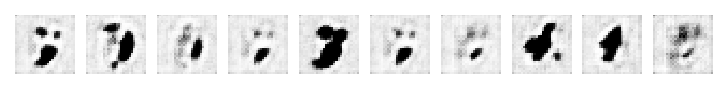

Epoch 2/150:
 [Elapsed 0:00:12] em_distance: 5.02648, loss_critic: -4.52050, loss_generator: 7.96864
Epoch 3/150:
 [Elapsed 0:00:12] em_distance: 3.89127, loss_critic: -3.54521, loss_generator: 5.73238
Epoch 4/150:
 [Elapsed 0:00:12] em_distance: 3.37246, loss_critic: -3.08972, loss_generator: 5.36922
Epoch 5/150:
 [Elapsed 0:00:12] em_distance: 3.07189, loss_critic: -2.82413, loss_generator: 4.98494
Epoch 6/150:
 [Elapsed 0:00:13] em_distance: 2.81266, loss_critic: -2.59182, loss_generator: 4.57688
Epoch 7/150:
 [Elapsed 0:00:12] em_distance: 2.61064, loss_critic: -2.41418, loss_generator: 4.52916
Epoch 8/150:
 [Elapsed 0:00:13] em_distance: 2.40757, loss_critic: -2.22725, loss_generator: 3.70657
Epoch 9/150:
 [Elapsed 0:00:12] em_distance: 2.15243, loss_critic: -2.00226, loss_generator: 3.25193
Epoch 10/150:
 [Elapsed 0:00:13] em_distance: 2.02162, loss_critic: -1.88193, loss_generator: 3.55597
Epoch 11/150:
 [Elapsed 0:00:12] em_distance: 1.85254, loss_critic: -1.72821, loss_generat

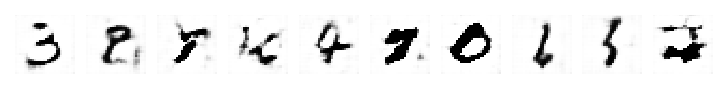

Epoch 12/150:
 [Elapsed 0:00:12] em_distance: 1.84384, loss_critic: -1.72035, loss_generator: 1.46063
Epoch 13/150:
 [Elapsed 0:00:13] em_distance: 1.70558, loss_critic: -1.59588, loss_generator: 1.78483
Epoch 14/150:
 [Elapsed 0:00:12] em_distance: 1.60801, loss_critic: -1.50771, loss_generator: 1.82611
Epoch 15/150:
 [Elapsed 0:00:13] em_distance: 1.62329, loss_critic: -1.51983, loss_generator: 2.86338
Epoch 16/150:
 [Elapsed 0:00:13] em_distance: 1.55336, loss_critic: -1.45762, loss_generator: 3.25735
Epoch 17/150:
 [Elapsed 0:00:12] em_distance: 1.57127, loss_critic: -1.47363, loss_generator: 3.73506
Epoch 18/150:
 [Elapsed 0:00:13] em_distance: 1.50006, loss_critic: -1.41133, loss_generator: 3.22291
Epoch 19/150:
 [Elapsed 0:00:13] em_distance: 1.44883, loss_critic: -1.36284, loss_generator: 3.24654
Epoch 20/150:
 [Elapsed 0:00:13] em_distance: 1.43875, loss_critic: -1.35332, loss_generator: 3.02032
Epoch 21/150:
 [Elapsed 0:00:13] em_distance: 1.41642, loss_critic: -1.33153, loss

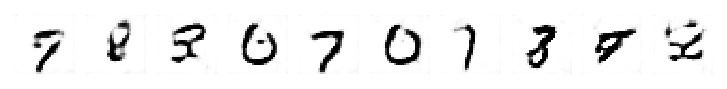

Epoch 22/150:
 [Elapsed 0:00:13] em_distance: 1.38554, loss_critic: -1.30516, loss_generator: 3.57821
Epoch 23/150:
 [Elapsed 0:00:12] em_distance: 1.37369, loss_critic: -1.29452, loss_generator: 2.93299
Epoch 24/150:
 [Elapsed 0:00:13] em_distance: 1.27167, loss_critic: -1.19945, loss_generator: 2.21309
Epoch 25/150:
 [Elapsed 0:00:13] em_distance: 1.23883, loss_critic: -1.17174, loss_generator: 2.36678
Epoch 26/150:
 [Elapsed 0:00:12] em_distance: 1.25481, loss_critic: -1.18600, loss_generator: 2.60154
Epoch 27/150:
 [Elapsed 0:00:13] em_distance: 1.22070, loss_critic: -1.15553, loss_generator: 2.50820
Epoch 28/150:
 [Elapsed 0:00:13] em_distance: 1.19384, loss_critic: -1.12932, loss_generator: 2.60639
Epoch 29/150:
 [Elapsed 0:00:13] em_distance: 1.13503, loss_critic: -1.07568, loss_generator: 2.11148
Epoch 30/150:
 [Elapsed 0:00:13] em_distance: 1.13095, loss_critic: -1.07192, loss_generator: 2.11443
Epoch 31/150:
 [Elapsed 0:00:12] em_distance: 1.17086, loss_critic: -1.11063, loss

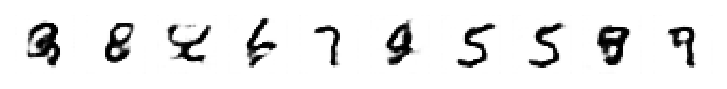

Epoch 32/150:
 [Elapsed 0:00:13] em_distance: 1.09930, loss_critic: -1.04446, loss_generator: 2.61757
Epoch 33/150:
 [Elapsed 0:00:13] em_distance: 1.10455, loss_critic: -1.04808, loss_generator: 2.34524
Epoch 34/150:
 [Elapsed 0:00:13] em_distance: 1.08167, loss_critic: -1.02615, loss_generator: 2.58847
Epoch 35/150:
 [Elapsed 0:00:13] em_distance: 1.09007, loss_critic: -1.03513, loss_generator: 2.65815
Epoch 36/150:
 [Elapsed 0:00:13] em_distance: 1.10711, loss_critic: -1.05272, loss_generator: 2.21389
Epoch 37/150:
 [Elapsed 0:00:13] em_distance: 1.07010, loss_critic: -1.01867, loss_generator: 1.57818
Epoch 38/150:
 [Elapsed 0:00:13] em_distance: 1.06327, loss_critic: -1.01150, loss_generator: 2.21225
Epoch 39/150:
 [Elapsed 0:00:12] em_distance: 1.00861, loss_critic: -0.95821, loss_generator: 2.83495
Epoch 40/150:
 [Elapsed 0:00:13] em_distance: 1.00179, loss_critic: -0.95176, loss_generator: 2.51504
Epoch 41/150:
 [Elapsed 0:00:13] em_distance: 0.98360, loss_critic: -0.93576, loss

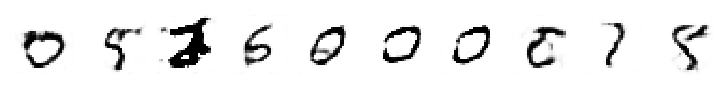

Epoch 42/150:
 [Elapsed 0:00:12] em_distance: 0.96405, loss_critic: -0.91811, loss_generator: 1.87636
Epoch 43/150:
 [Elapsed 0:00:13] em_distance: 1.01084, loss_critic: -0.96155, loss_generator: 1.54884
Epoch 44/150:
 [Elapsed 0:00:13] em_distance: 1.00627, loss_critic: -0.96021, loss_generator: 2.08672
Epoch 45/150:
 [Elapsed 0:00:12] em_distance: 0.96117, loss_critic: -0.91552, loss_generator: 2.99133
Epoch 46/150:
 [Elapsed 0:00:13] em_distance: 0.95040, loss_critic: -0.90593, loss_generator: 3.04842
Epoch 47/150:
 [Elapsed 0:00:13] em_distance: 0.93270, loss_critic: -0.88763, loss_generator: 2.94766
Epoch 48/150:
 [Elapsed 0:00:12] em_distance: 0.93463, loss_critic: -0.89016, loss_generator: 2.92143
Epoch 49/150:
 [Elapsed 0:00:13] em_distance: 0.93950, loss_critic: -0.89427, loss_generator: 2.71823
Epoch 50/150:
 [Elapsed 0:00:13] em_distance: 0.95363, loss_critic: -0.90864, loss_generator: 3.11490
Epoch 51/150:
 [Elapsed 0:00:12] em_distance: 0.92165, loss_critic: -0.87819, loss

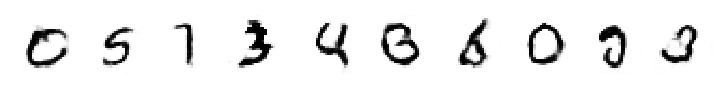

Epoch 52/150:
 [Elapsed 0:00:12] em_distance: 0.90706, loss_critic: -0.86367, loss_generator: 1.65160
Epoch 53/150:
 [Elapsed 0:00:13] em_distance: 0.89473, loss_critic: -0.85239, loss_generator: 2.60208
Epoch 54/150:
 [Elapsed 0:00:13] em_distance: 0.87265, loss_critic: -0.83138, loss_generator: 2.39484
Epoch 55/150:
 [Elapsed 0:00:12] em_distance: 0.88750, loss_critic: -0.84472, loss_generator: 2.11222
Epoch 56/150:
 [Elapsed 0:00:13] em_distance: 0.89783, loss_critic: -0.85776, loss_generator: 2.78469
Epoch 57/150:
 [Elapsed 0:00:12] em_distance: 0.88042, loss_critic: -0.83964, loss_generator: 2.76182
Epoch 58/150:
 [Elapsed 0:00:12] em_distance: 0.86611, loss_critic: -0.82671, loss_generator: 2.44600
Epoch 59/150:
 [Elapsed 0:00:13] em_distance: 0.85970, loss_critic: -0.82033, loss_generator: 1.68768
Epoch 60/150:
 [Elapsed 0:00:12] em_distance: 0.90334, loss_critic: -0.86327, loss_generator: 2.54909
Epoch 61/150:
 [Elapsed 0:00:12] em_distance: 0.95096, loss_critic: -0.90827, loss

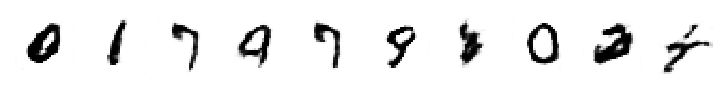

Epoch 62/150:
 [Elapsed 0:00:13] em_distance: 0.87081, loss_critic: -0.83141, loss_generator: 2.79826
Epoch 63/150:
 [Elapsed 0:00:12] em_distance: 0.87237, loss_critic: -0.83356, loss_generator: 1.48299
Epoch 64/150:
 [Elapsed 0:00:12] em_distance: 0.85487, loss_critic: -0.81652, loss_generator: 1.62805
Epoch 65/150:
 [Elapsed 0:00:12] em_distance: 0.88117, loss_critic: -0.84236, loss_generator: 1.64525
Epoch 66/150:
 [Elapsed 0:00:12] em_distance: 0.88589, loss_critic: -0.84686, loss_generator: 2.95985
Epoch 67/150:
 [Elapsed 0:00:12] em_distance: 0.85851, loss_critic: -0.81955, loss_generator: 1.69814
Epoch 68/150:
 [Elapsed 0:00:13] em_distance: 0.86256, loss_critic: -0.82497, loss_generator: 2.29802
Epoch 69/150:
 [Elapsed 0:00:12] em_distance: 0.86627, loss_critic: -0.82747, loss_generator: 2.86016
Epoch 70/150:
 [Elapsed 0:00:12] em_distance: 0.83223, loss_critic: -0.79355, loss_generator: 2.52102
Epoch 71/150:
 [Elapsed 0:00:12] em_distance: 0.79267, loss_critic: -0.75704, loss

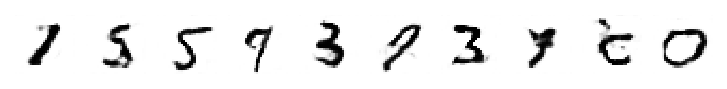

Epoch 72/150:
 [Elapsed 0:00:12] em_distance: 0.80554, loss_critic: -0.76981, loss_generator: 2.55393
Epoch 73/150:
 [Elapsed 0:00:13] em_distance: 0.83535, loss_critic: -0.79863, loss_generator: 1.87740
Epoch 74/150:
 [Elapsed 0:00:12] em_distance: 0.82197, loss_critic: -0.78697, loss_generator: 2.93740
Epoch 75/150:
 [Elapsed 0:00:13] em_distance: 0.82388, loss_critic: -0.78783, loss_generator: 1.50545
Epoch 76/150:
 [Elapsed 0:00:12] em_distance: 0.83525, loss_critic: -0.79963, loss_generator: 1.86370
Epoch 77/150:
 [Elapsed 0:00:12] em_distance: 0.80209, loss_critic: -0.76687, loss_generator: 2.02527
Epoch 78/150:
 [Elapsed 0:00:13] em_distance: 0.79744, loss_critic: -0.76161, loss_generator: 2.31994
Epoch 79/150:
 [Elapsed 0:00:12] em_distance: 0.79634, loss_critic: -0.76162, loss_generator: 2.19966
Epoch 80/150:
 [Elapsed 0:00:13] em_distance: 0.77642, loss_critic: -0.74188, loss_generator: 3.32965
Epoch 81/150:
 [Elapsed 0:00:13] em_distance: 0.76503, loss_critic: -0.73152, loss

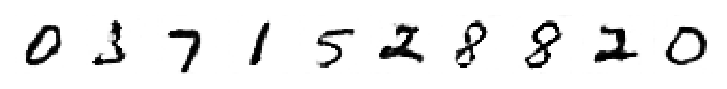

Epoch 82/150:
 [Elapsed 0:00:12] em_distance: 0.75856, loss_critic: -0.72545, loss_generator: 2.45232
Epoch 83/150:
 [Elapsed 0:00:12] em_distance: 0.79870, loss_critic: -0.76430, loss_generator: 2.00063
Epoch 84/150:
 [Elapsed 0:00:13] em_distance: 0.79425, loss_critic: -0.76125, loss_generator: 1.76670
Epoch 85/150:
 [Elapsed 0:00:13] em_distance: 0.73292, loss_critic: -0.70204, loss_generator: 2.35976
Epoch 86/150:
 [Elapsed 0:00:13] em_distance: 0.75014, loss_critic: -0.71805, loss_generator: 2.46253
Epoch 87/150:
 [Elapsed 0:00:12] em_distance: 0.73047, loss_critic: -0.69979, loss_generator: 1.93855
Epoch 88/150:
 [Elapsed 0:00:13] em_distance: 0.74798, loss_critic: -0.71579, loss_generator: 2.46014
Epoch 89/150:
 [Elapsed 0:00:12] em_distance: 0.74578, loss_critic: -0.71424, loss_generator: 1.22337
Epoch 90/150:
 [Elapsed 0:00:12] em_distance: 0.79587, loss_critic: -0.76149, loss_generator: 1.42692
Epoch 91/150:
 [Elapsed 0:00:13] em_distance: 0.75343, loss_critic: -0.72209, loss

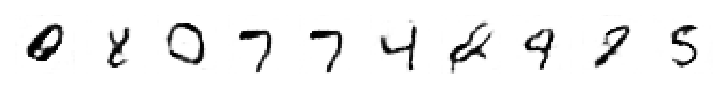

Epoch 92/150:
 [Elapsed 0:00:12] em_distance: 0.74799, loss_critic: -0.71749, loss_generator: 1.76240
Epoch 93/150:
 [Elapsed 0:00:13] em_distance: 0.75382, loss_critic: -0.72204, loss_generator: 1.98018
Epoch 94/150:
 [Elapsed 0:00:12] em_distance: 0.76256, loss_critic: -0.73033, loss_generator: 1.48525
Epoch 95/150:
 [Elapsed 0:00:13] em_distance: 0.74458, loss_critic: -0.71336, loss_generator: 0.92714
Epoch 96/150:
 [Elapsed 0:00:13] em_distance: 0.70998, loss_critic: -0.68161, loss_generator: 2.08092
Epoch 97/150:
 [Elapsed 0:00:12] em_distance: 0.73394, loss_critic: -0.70379, loss_generator: 2.54860
Epoch 98/150:
 [Elapsed 0:00:12] em_distance: 0.71536, loss_critic: -0.68651, loss_generator: 3.12177
Epoch 99/150:
 [Elapsed 0:00:13] em_distance: 0.70712, loss_critic: -0.67775, loss_generator: 2.77878
Epoch 100/150:
 [Elapsed 0:00:12] em_distance: 0.71562, loss_critic: -0.68566, loss_generator: 3.46454
Epoch 101/150:
 [Elapsed 0:00:12] em_distance: 0.73970, loss_critic: -0.70908, lo

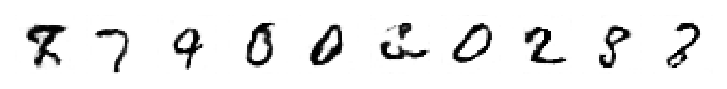

Epoch 102/150:
 [Elapsed 0:00:13] em_distance: 0.70844, loss_critic: -0.67909, loss_generator: 3.21654
Epoch 103/150:
 [Elapsed 0:00:13] em_distance: 0.71184, loss_critic: -0.68293, loss_generator: 3.11486
Epoch 104/150:
 [Elapsed 0:00:12] em_distance: 0.69097, loss_critic: -0.66319, loss_generator: 2.78200
Epoch 105/150:
 [Elapsed 0:00:13] em_distance: 0.74406, loss_critic: -0.71448, loss_generator: 3.12584
Epoch 106/150:
 [Elapsed 0:00:13] em_distance: 0.73995, loss_critic: -0.70904, loss_generator: 3.24779
Epoch 107/150:
 [Elapsed 0:00:13] em_distance: 0.70248, loss_critic: -0.67367, loss_generator: 4.68401
Epoch 108/150:
 [Elapsed 0:00:12] em_distance: 0.69463, loss_critic: -0.66659, loss_generator: 3.33588
Epoch 109/150:
 [Elapsed 0:00:12] em_distance: 0.68756, loss_critic: -0.66004, loss_generator: 2.67608
Epoch 110/150:
 [Elapsed 0:00:13] em_distance: 0.70582, loss_critic: -0.67765, loss_generator: 3.27587
Epoch 111/150:
 [Elapsed 0:00:13] em_distance: 0.69226, loss_critic: -0.6

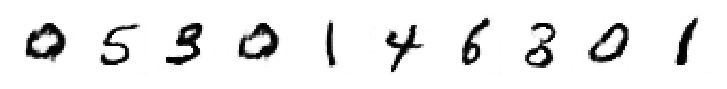

Epoch 112/150:
 [Elapsed 0:00:12] em_distance: 0.70715, loss_critic: -0.67883, loss_generator: 3.29013
Epoch 113/150:
 [Elapsed 0:00:12] em_distance: 0.70190, loss_critic: -0.67326, loss_generator: 3.79584
Epoch 114/150:
 [Elapsed 0:00:12] em_distance: 0.67310, loss_critic: -0.64665, loss_generator: 2.87875
Epoch 115/150:
 [Elapsed 0:00:13] em_distance: 0.69709, loss_critic: -0.66910, loss_generator: 3.23763
Epoch 116/150:
 [Elapsed 0:00:13] em_distance: 0.69022, loss_critic: -0.66291, loss_generator: 4.03897
Epoch 117/150:
 [Elapsed 0:00:13] em_distance: 0.68372, loss_critic: -0.65623, loss_generator: 4.06759
Epoch 118/150:
 [Elapsed 0:00:12] em_distance: 0.69353, loss_critic: -0.66495, loss_generator: 5.12880
Epoch 119/150:
 [Elapsed 0:00:13] em_distance: 0.70090, loss_critic: -0.67294, loss_generator: 3.55612
Epoch 120/150:
 [Elapsed 0:00:12] em_distance: 0.70826, loss_critic: -0.68002, loss_generator: 3.54234
Epoch 121/150:
 [Elapsed 0:00:13] em_distance: 0.70282, loss_critic: -0.6

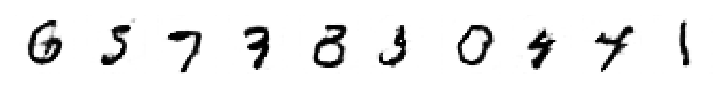

Epoch 122/150:
 [Elapsed 0:00:12] em_distance: 0.68034, loss_critic: -0.65269, loss_generator: 3.47914
Epoch 123/150:
 [Elapsed 0:00:13] em_distance: 0.67002, loss_critic: -0.64325, loss_generator: 3.57539
Epoch 124/150:
 [Elapsed 0:00:12] em_distance: 0.68075, loss_critic: -0.65313, loss_generator: 3.60939
Epoch 125/150:
 [Elapsed 0:00:13] em_distance: 0.67824, loss_critic: -0.65114, loss_generator: 4.47972
Epoch 126/150:
 [Elapsed 0:00:13] em_distance: 0.66614, loss_critic: -0.64036, loss_generator: 3.84233
Epoch 127/150:
 [Elapsed 0:00:13] em_distance: 0.67027, loss_critic: -0.64338, loss_generator: 4.54715
Epoch 128/150:
 [Elapsed 0:00:12] em_distance: 0.65435, loss_critic: -0.62803, loss_generator: 4.02672
Epoch 129/150:
 [Elapsed 0:00:12] em_distance: 0.66310, loss_critic: -0.63783, loss_generator: 3.85094
Epoch 130/150:
 [Elapsed 0:00:12] em_distance: 0.64587, loss_critic: -0.62064, loss_generator: 3.67754
Epoch 131/150:
 [Elapsed 0:00:13] em_distance: 0.66862, loss_critic: -0.6

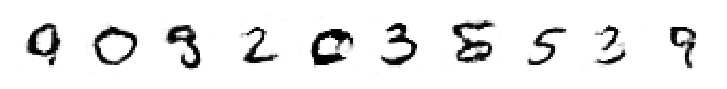

Epoch 132/150:
 [Elapsed 0:00:13] em_distance: 0.68400, loss_critic: -0.65685, loss_generator: 3.12470
Epoch 133/150:
 [Elapsed 0:00:13] em_distance: 0.66093, loss_critic: -0.63521, loss_generator: 5.02649
Epoch 134/150:
 [Elapsed 0:00:12] em_distance: 0.65790, loss_critic: -0.63186, loss_generator: 4.46611
Epoch 135/150:
 [Elapsed 0:00:13] em_distance: 0.67293, loss_critic: -0.64663, loss_generator: 4.14123
Epoch 136/150:
 [Elapsed 0:00:12] em_distance: 0.65694, loss_critic: -0.63188, loss_generator: 4.27878
Epoch 137/150:
 [Elapsed 0:00:13] em_distance: 0.65135, loss_critic: -0.62593, loss_generator: 3.48673
Epoch 138/150:
 [Elapsed 0:00:13] em_distance: 0.64379, loss_critic: -0.61912, loss_generator: 3.28106
Epoch 139/150:
 [Elapsed 0:00:12] em_distance: 0.61404, loss_critic: -0.58964, loss_generator: 3.60245
Epoch 140/150:
 [Elapsed 0:00:13] em_distance: 0.63890, loss_critic: -0.61458, loss_generator: 3.90019
Epoch 141/150:
 [Elapsed 0:00:13] em_distance: 0.64279, loss_critic: -0.6

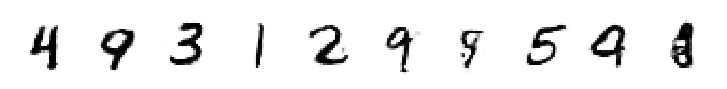

Epoch 142/150:
 [Elapsed 0:00:12] em_distance: 0.67299, loss_critic: -0.64657, loss_generator: 4.11551
Epoch 143/150:
 [Elapsed 0:00:13] em_distance: 0.61639, loss_critic: -0.59260, loss_generator: 3.47062
Epoch 144/150:
 [Elapsed 0:00:12] em_distance: 0.61978, loss_critic: -0.59622, loss_generator: 3.48426
Epoch 145/150:
 [Elapsed 0:00:13] em_distance: 0.64605, loss_critic: -0.62084, loss_generator: 3.85655
Epoch 146/150:
 [Elapsed 0:00:13] em_distance: 0.62657, loss_critic: -0.60150, loss_generator: 4.35992
Epoch 147/150:
 [Elapsed 0:00:12] em_distance: 0.61979, loss_critic: -0.59559, loss_generator: 4.69366
Epoch 148/150:
 [Elapsed 0:00:13] em_distance: 0.62909, loss_critic: -0.60492, loss_generator: 3.77995
Epoch 149/150:
 [Elapsed 0:00:12] em_distance: 0.63945, loss_critic: -0.61499, loss_generator: 5.09469
Epoch 150/150:
 [Elapsed 0:00:12] em_distance: 0.65358, loss_critic: -0.62849, loss_generator: 3.92858


In [16]:
history = engine.train(
    zip_loader,
    epochs=150,
    generator_optimizer=generator_optimizer,
    critic_optimizer=critic_optimizer,
    generator_loss=generator_loss,
    critic_loss=critic_loss,
    critic_iterations=critic_iterations,
    callbacks=[
        xnn.BatchProgressLogger(),
        Callback(model.generator)
    ]
)

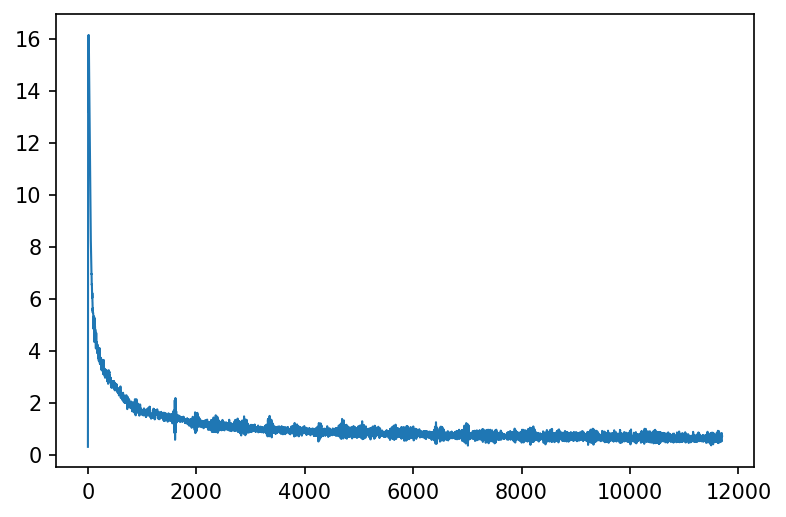

In [17]:
all_losses = history.batch_em_distance
plt.figure(dpi=150)
plt.plot(range(len(all_losses)), all_losses, linewidth=1)
plt.show()

In [27]:
noise = next(iter(noise_loader))

In [28]:
out = model.generator(noise).detach().numpy()

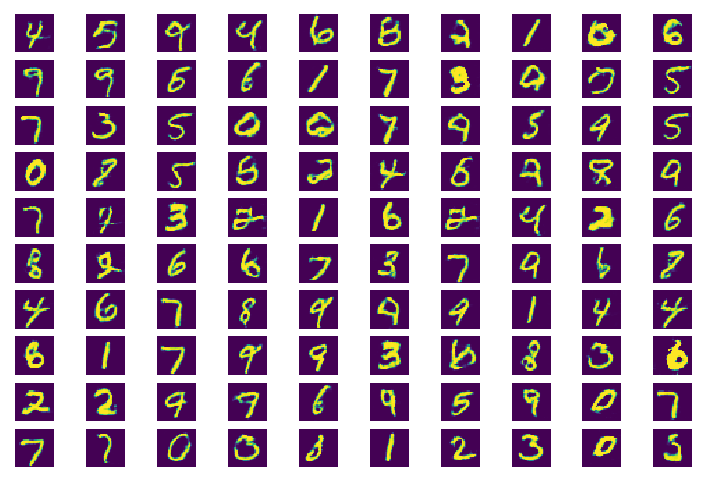

In [34]:
plt.figure(dpi=150)

for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(out[i].reshape(28, 28))
    plt.axis('off')

plt.show()